<a href="https://colab.research.google.com/github/min02yam/R-study/blob/main/220821.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.패키지 및 데이터 로드

In [1]:
system("gdown --id 1Op15dbRxlDyOtGTxrYvm88OcdBmo0dSL") # train
system("gdown --id 1B0tuhqv9KpxFYfy4ydNAACg8NpvhBa9N") # test

In [3]:
suppressPackageStartupMessages({
require(data.table)
require(magrittr)
require(dplyr)
require(lubridate)
})

In [9]:
#install.packages("DataExplorer")
#library(DataExplorer)
install.packages("skimr")
library(skimr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
dt = fread("train.csv")

# 1.BASIC EDA

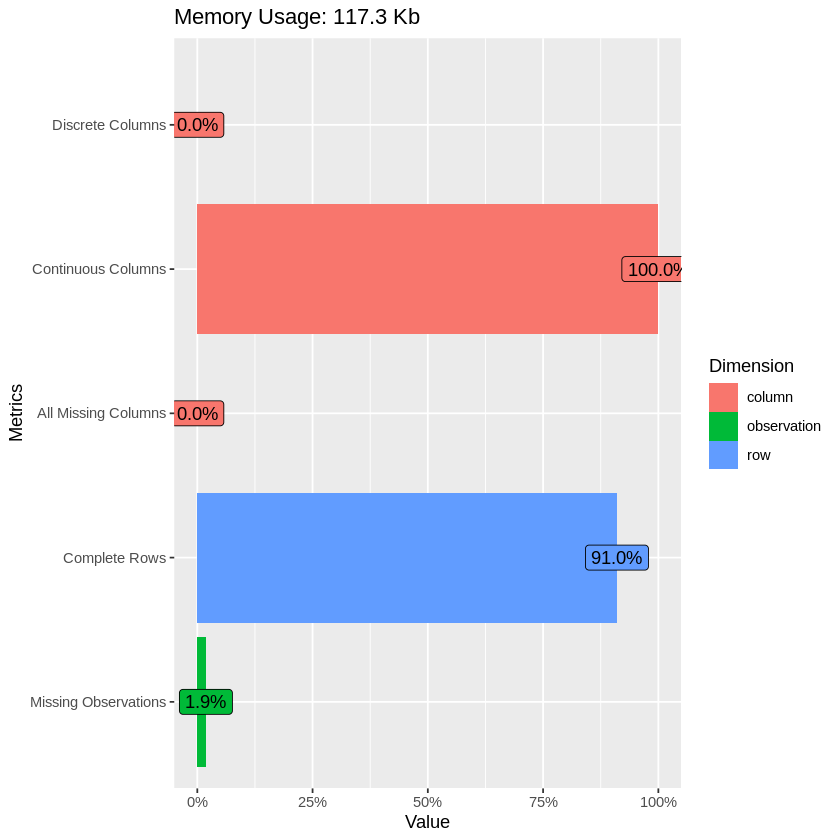

In [6]:
plot_intro(dt)

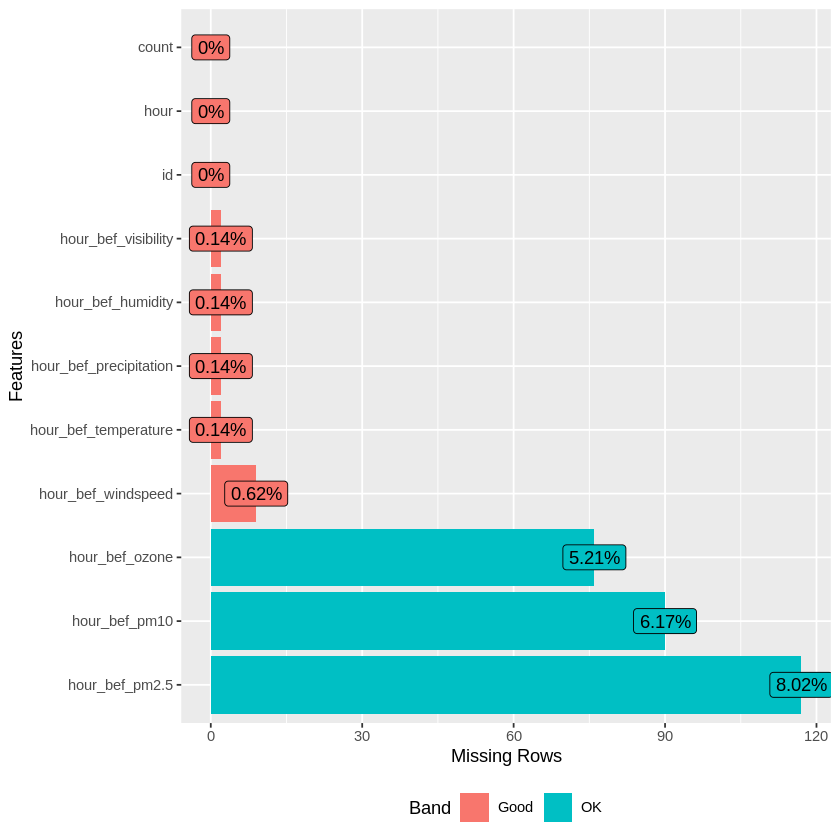

In [7]:
plot_missing(dt)

In [10]:
skim(dt)

── Data Summary ────────────────────────
                           Values
Name                       dt    
Number of rows             1459  
Number of columns          11    
Key                        NULL  
_______________________          
Column type frequency:           
  numeric                  11    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable          n_missing complete_rate      mean       sd     p0
 1 id                             0         1     1106.     631.      3    
 2 hour                           0         1       11.5      6.92    0    
 3 hour_bef_temperature           2         0.999   16.7      5.24    3.1  
 4 hour_bef_precipitation         2         0.999    0.0316   0.175   0    
 5 hour_bef_windspeed             9         0.994    2.48     1.38    0    
 6 hour_bef_humidity              2         0.999   52.2     20.4     7    
 7 ho

1.  다 뉴메릭
2.  id, hour, count 변수 빼고 다 미싱 존재

## 1-1.라벨링

In [ ]:
substr()

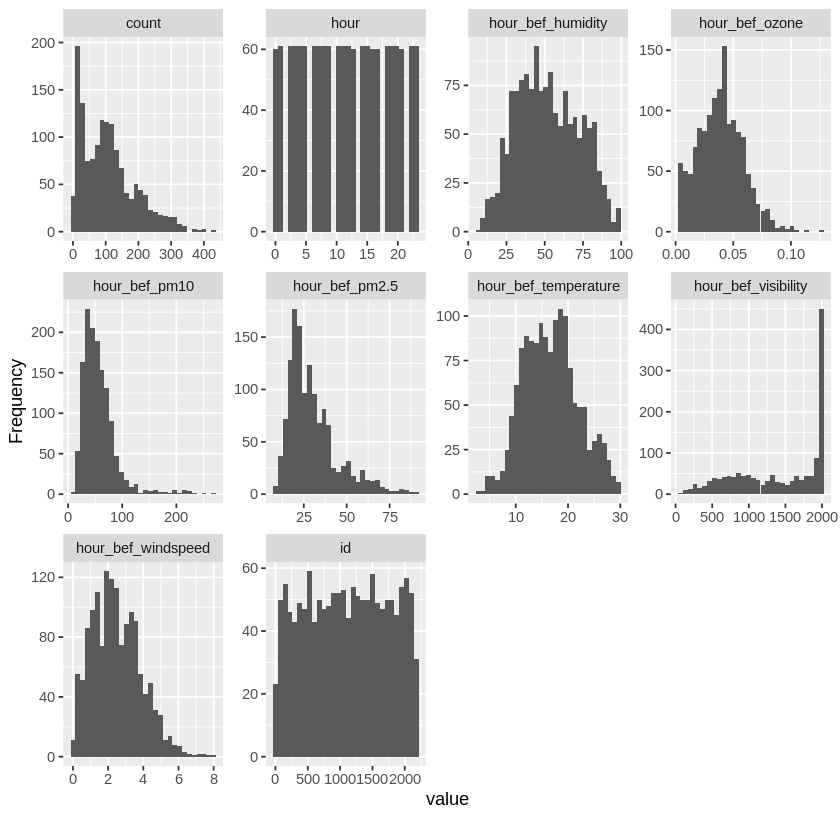

In [13]:
plot_histogram(dt)

# 2.이상치 처리
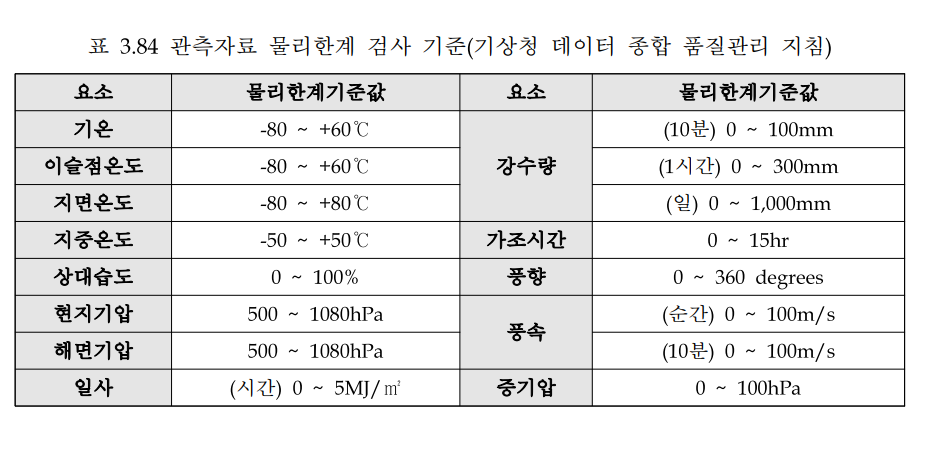

도메인으로 봤을때 이상치가 없다고 판단하고, 대기환경 변수만 0.999퀀타일 값을 기준으로 결측치로 처리함 

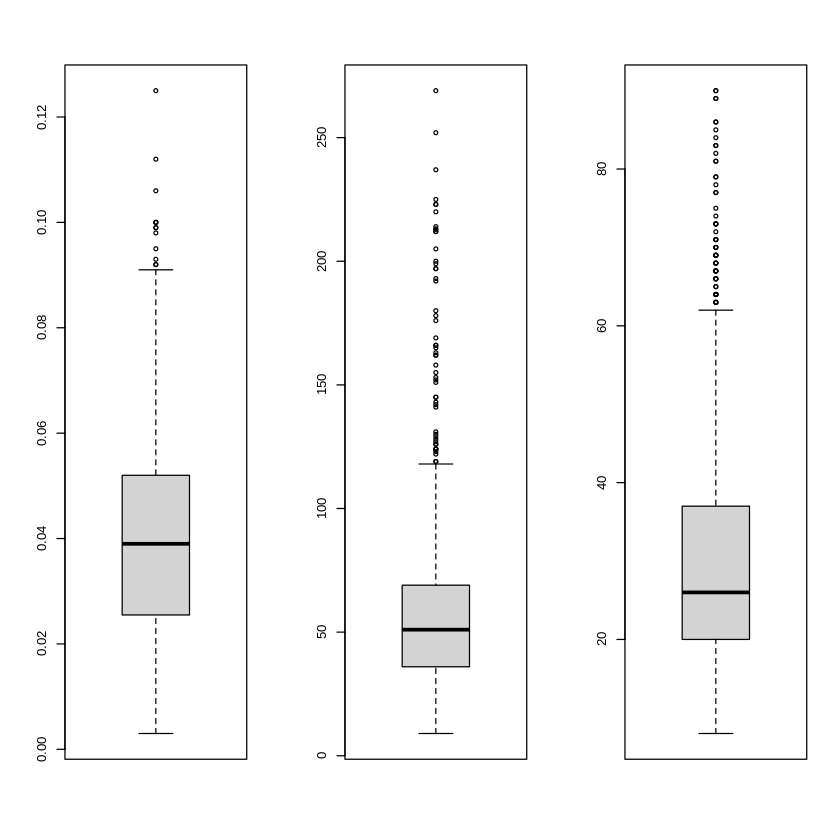

In [61]:
par(mfrow=c(1,3))
boxplot(dt[,8])
boxplot(dt[,9])
boxplot(dt[,10])

In [62]:
quantile(dt[,'ozon'], probs=c(0.999))
#ozon_up = 
#pm10 = quantile()
#pm25 = quantile()

ERROR: ignored